In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import torch.nn.functional as F
from PIL import Image
import random

In [2]:
def plot_simple_confusion_matrix(model, dataloader, classes):
    model.eval()  # Set the model to evaluation mode
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Iterate over the data loader and get predictions
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in dataloader:  # Iterate through batches in the dataloader
            outputs = model(images)  # Forward pass through the model
            _, predicted = torch.max(outputs, 1)  # Get predicted class (index of max output)
            # This line finds the class with the highest predicted probability. torch.max() returns two values: 
            # the maximum value and the index of that value. We only need the index, which is the predicted class
            y_true.extend(labels.cpu().numpy())  # Append true labels to y_true
            y_pred.extend(predicted.cpu().numpy())  # Append predicted labels to y_pred
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(3, 3))  # Set figure size
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Display the confusion matrix as an image
    plt.title("Confusion Matrix")
    # plt.colorbar()  # Display a color bar

    # Add labels for the axes
    tick_marks = np.arange(len(classes))  # Generate tick positions for each class
    plt.xticks(tick_marks, classes, rotation=45)  # Set the x-axis ticks (predicted labels) and rotate the labels by 45 degrees
    plt.yticks(tick_marks, classes)  # Set the y-axis ticks (true labels)

    # Display the values inside the matrix
    for i in range(len(classes)):  # Loop over each class
        for j in range(len(classes)):  # Loop over each predicted class
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()  
    plt.show()  

### Importing and Preprocessing of data

Dimensioni originali dell'immagine: (224, 224)
Dimensioni trasformate: torch.Size([3, 128, 128])


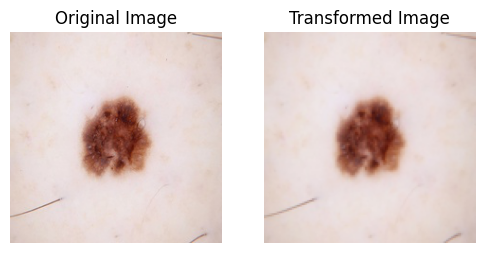

In [4]:
# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a fixed size of 128x128 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image channels = colored (R, G, B) to have mean 0.5 and std 0.5
])

# Define the dataset path
dataset_path = '/home/laura/Desktop/OsloUni/ML/Project3/archive/'

# Load sample image without transformation
image_path = os.path.join(dataset_path, 'benign', '0019.jpg')
original_image = Image.open(image_path)

# Original dimensions
original_size = original_image.size
print(f"Dimensioni originali dell'immagine: {original_size}")

# Load the dataset with transformations
dataset = datasets.ImageFolder(os.path.join(dataset_path), transform=transform)

# Load one sample image with transformations
image, label = dataset[19]  # Getting the first image from the dataset with transformations

# Convert tensor image to image for display purposes
def tensor_to_pil(tensor_image):
    # Undo the normalization and convert back to a range [0, 1] and then to PIL
    tensor_image = tensor_image / 2 + 0.5  # Denormalize to [0, 1]
    image = tensor_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC
    image = (image * 255).astype('uint8')  # Convert to uint8 format for PIL compatibility
    return Image.fromarray(image)

# Apply transformation to the image
transformed_image = tensor_to_pil(image)

# Tranformed image dimensions
transformed_size = image.shape
print(f"Dimensioni trasformate: {transformed_size}")

# Plot the original and transformed images
plt.figure(figsize=(6, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Display the transformed image
plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title("Transformed Image")
plt.axis('off')

plt.show()

In [3]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a fixed size of 128x128 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image channels = colored (R, G, B) to have mean 0.5 and std 0.5
])

# Loading the dataset using ImageFolder
dataset_path = '/home/laura/Desktop/OsloUni/ML/Project3/archive/'
dataset = datasets.ImageFolder(os.path.join(dataset_path), transform=transform)
# The ImageFolder class assumes the dataset is organized into subfolders representing class labels.
# The `transform` argument ensures that all images undergo the specified transformations.

# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of the dataset for training
val_size = int(0.15 * len(dataset))   # 15% of the dataset for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Perform the actual split
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders for each set
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)  # Shuffle the training data for randomness
valloader = DataLoader(val_set, batch_size=32, shuffle=False)     # No shuffling for validation
testloader = DataLoader(test_set, batch_size=32, shuffle=False)   # No shuffling for testing

# Defining the class labels
classes = ['benign', 'malignant']  # The two categories of images in this dataset
# These labels correspond to the subfolder names in the dataset directory structure.

In [4]:
# Sizes of training, validation, and test sets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 2307
Validation set size: 494
Test set size: 496


In [5]:
# Check the number of batches 
print(f"Number of batches in training set: {len(trainloader)}")
print(f"Number of batches in validation set: {len(valloader)}")
print(f"Number of batches in test set: {len(testloader)}")

# Size of one batch from the trainloader
example_batch = next(iter(trainloader))
# size of one batch
print(f"Batch input shape: {example_batch[0].shape}")  # Shape of the images in the batch [batch_size, 3, 128, 128] 
# 32 immagini, ciascuna con 3 canali (RGB), 128x128 pixel
print(f"Batch label shape: {example_batch[1].shape}")  # Shape of the labels in the batch

Number of batches in training set: 73
Number of batches in validation set: 16
Number of batches in test set: 16
Batch input shape: torch.Size([32, 3, 128, 128])
Batch label shape: torch.Size([32])


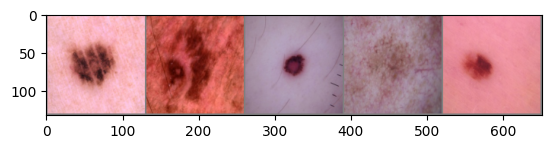

        benign      malignant    benign      malignant    benign  


In [41]:
def imshow(img):
    # This function displays an image. 
    # First, it "unnormalizes" the image by scaling it back from the range [-1, 1] to [0, 1].
    img = img / 2 + 0.5  # unnormalize: Scaling the pixel values back from [-1, 1] to [0, 1]
    
    # Convert the tensor image to a NumPy array so that it can be processed by matplotlib.
    npimg = img.numpy()  # Convert the tensor to a NumPy array
    
    # The image in the tensor is in the format (C, H, W), 
    # where C is the number of channels (e.g., 3 for RGB), 
    # H is height (image height), and W is width (image width).
    # But `imshow()` expects an image in the format (H, W, C) - height, width, channels.
    # This line transposes the dimensions to match the required format.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions from (C, H, W) to (H, W, C)
    
    plt.show()

# get some random training images from the training data loader
dataiter = iter(trainloader)  # Create an iterator from the trainloader

# Get the first batch of images and their corresponding labels
images, labels = next(dataiter)  # Get the first batch of images and labels

# Show the first 5 images in the batch using the imshow function
# torchvision.utils.make_grid takes a batch of images and arranges them in a grid format.
# images[:5] selects the first 5 images from the batch.
imshow(torchvision.utils.make_grid(images[:5]))  # Display the first 5 images in a grid

# Print the labels of the first 5 images. 
# `classes[labels[j]]` maps the label (integer) to the corresponding class name.
# `f'{classes[labels[j]]:8s}'` formats the class names into a string, with 8 characters width for alignment.
print('       ','    '.join(f'{classes[labels[j]]:8s}' for j in range(5)))  
# This prints the class names of the first 5 images (e.g., "benign", "malignant").

### CNN

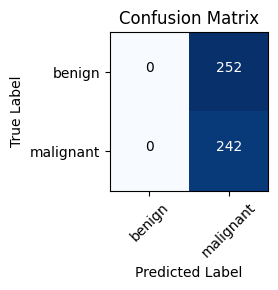

In [47]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Fully connected layer (input size: 32*32*32, output size: 128)
        self.fc2 = nn.Linear(128, 2)  # Fully connected layer (input size: 128, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x

net = Net()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net, valloader, classes)

In [48]:
print("Accuracy before training on validation set: ",round(242/(252 + 242),4))

Accuracy before training on validation set:  0.4899


In [49]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

model_path = "./skin_lesion_classifier.pth"  # Path where the model will be saved
torch.save(net.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

Epoch 1: Train Accuracy: 78.50%, Val Accuracy: 76.72%
Epoch 2: Train Accuracy: 82.36%, Val Accuracy: 80.77%
Epoch 3: Train Accuracy: 84.66%, Val Accuracy: 79.15%
Epoch 4: Train Accuracy: 86.65%, Val Accuracy: 81.98%
Epoch 5: Train Accuracy: 88.30%, Val Accuracy: 83.00%
Epoch 6: Train Accuracy: 91.03%, Val Accuracy: 84.62%
Epoch 7: Train Accuracy: 91.94%, Val Accuracy: 81.17%
Epoch 8: Train Accuracy: 93.97%, Val Accuracy: 79.96%
Epoch 9: Train Accuracy: 96.92%, Val Accuracy: 81.58%
Epoch 10: Train Accuracy: 97.27%, Val Accuracy: 82.19%
Epoch 11: Train Accuracy: 98.48%, Val Accuracy: 83.60%
Epoch 12: Train Accuracy: 99.57%, Val Accuracy: 80.57%
Epoch 13: Train Accuracy: 96.88%, Val Accuracy: 79.96%
Epoch 14: Train Accuracy: 97.83%, Val Accuracy: 78.14%
Epoch 15: Train Accuracy: 99.26%, Val Accuracy: 83.81%
Epoch 16: Train Accuracy: 100.00%, Val Accuracy: 83.40%
Epoch 17: Train Accuracy: 100.00%, Val Accuracy: 83.81%
Epoch 18: Train Accuracy: 100.00%, Val Accuracy: 83.20%
Epoch 19: Train 

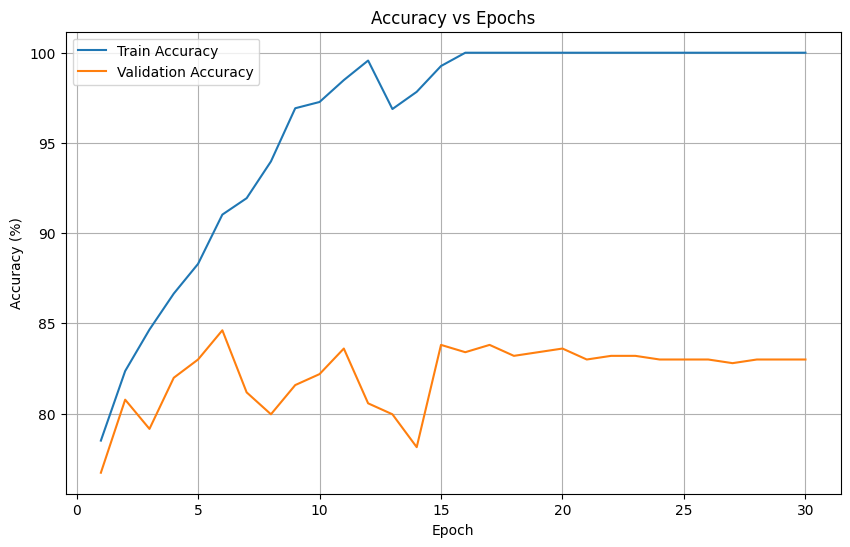

In [56]:
# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

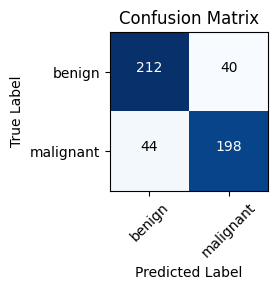

In [57]:
# Loading trained model for final evaluation
net = Net()
net.load_state_dict(torch.load(model_path, weights_only=True))
net.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net, valloader, classes)

In [58]:
# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

Accuracy for class on Validation: benign is 84.1 %
Accuracy for class on Validation: malignant is 81.8 %
Total Accuracy on Validation set: 83.00%


In [59]:
# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

Accuracy for class on Test set: benign is 85.2 %
Accuracy for class on Test set: malignant is 76.7 %
Total Accuracy on Test set: 81.45%


## SAME CODE BUT DIFFERENT CNN ARCHITECTURES

### Different number of nodes in hidden layers (64 instead of 128)

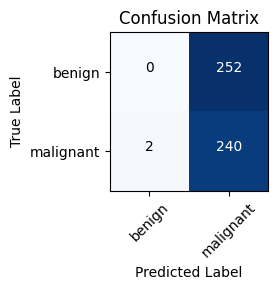

In [60]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net1(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)  # Fully connected layer (input size: 32*32*32, output size: 64)
        self.fc2 = nn.Linear(64, 2)  # Fully connected layer (input size: 64, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x

net1 = Net1()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net1.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net1, valloader, classes)

In [61]:
print("Accuracy before training on validation set: ",round(240/(252 + 2 + 240),4))

Accuracy before training on validation set:  0.4858


In [62]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net1.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net1(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net1.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net1(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier.pth"  # Path where the model will be saved
torch.save(net1.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

Epoch 1: Train Accuracy: 77.76%, Val Accuracy: 79.76%
Epoch 2: Train Accuracy: 83.14%, Val Accuracy: 79.15%
Epoch 3: Train Accuracy: 84.92%, Val Accuracy: 80.16%
Epoch 4: Train Accuracy: 85.65%, Val Accuracy: 80.77%
Epoch 5: Train Accuracy: 87.78%, Val Accuracy: 82.79%
Epoch 6: Train Accuracy: 90.42%, Val Accuracy: 82.59%
Epoch 7: Train Accuracy: 92.54%, Val Accuracy: 82.19%
Epoch 8: Train Accuracy: 94.41%, Val Accuracy: 82.79%
Epoch 9: Train Accuracy: 96.01%, Val Accuracy: 83.00%
Epoch 10: Train Accuracy: 96.66%, Val Accuracy: 83.20%
Epoch 11: Train Accuracy: 98.40%, Val Accuracy: 81.58%
Epoch 12: Train Accuracy: 97.88%, Val Accuracy: 82.39%
Epoch 13: Train Accuracy: 98.27%, Val Accuracy: 82.59%
Epoch 14: Train Accuracy: 99.05%, Val Accuracy: 82.19%
Epoch 15: Train Accuracy: 98.61%, Val Accuracy: 82.79%
Epoch 16: Train Accuracy: 99.05%, Val Accuracy: 82.79%
Epoch 17: Train Accuracy: 100.00%, Val Accuracy: 82.19%
Epoch 18: Train Accuracy: 100.00%, Val Accuracy: 83.81%
Epoch 19: Train A

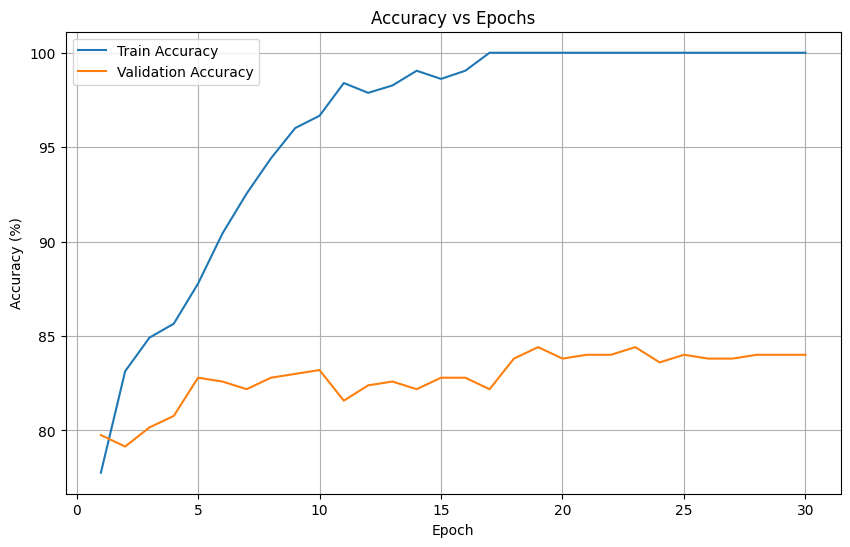

In [63]:
# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net1(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net1.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

Accuracy for class on Validation: benign is 86.9 %
Accuracy for class on Validation: malignant is 81.0 %
Total Accuracy on Validation set: 84.01%


In [66]:
# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net1.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

Accuracy for class on Test set: benign is 86.3 %
Accuracy for class on Test set: malignant is 82.2 %
Total Accuracy on Test set: 84.48%


### Different number of nodes in hidden layers (32 instead of 128)

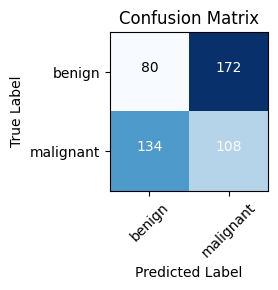

In [6]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net6(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net6, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 32)  # Fully connected layer (input size: 32*32*32, output size: 64)
        self.fc2 = nn.Linear(32, 2)  # Fully connected layer (input size: 64, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x

net6 = Net6()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net6.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net6, valloader, classes)

In [8]:
print("Accuracy before training on validation set: ",round((80+108)/(80+172+134+108),4))

Accuracy before training on validation set:  0.3806


In [9]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net6.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net6(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net6.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net6(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier.pth"  # Path where the model will be saved
torch.save(net6.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

Epoch 1: Train Accuracy: 77.63%, Val Accuracy: 79.55%
Epoch 2: Train Accuracy: 80.62%, Val Accuracy: 78.74%
Epoch 3: Train Accuracy: 82.18%, Val Accuracy: 79.15%
Epoch 4: Train Accuracy: 84.83%, Val Accuracy: 81.17%
Epoch 5: Train Accuracy: 84.83%, Val Accuracy: 82.59%
Epoch 6: Train Accuracy: 86.48%, Val Accuracy: 82.59%
Epoch 7: Train Accuracy: 88.86%, Val Accuracy: 84.41%
Epoch 8: Train Accuracy: 89.12%, Val Accuracy: 82.59%
Epoch 9: Train Accuracy: 91.85%, Val Accuracy: 83.00%
Epoch 10: Train Accuracy: 92.85%, Val Accuracy: 81.98%
Epoch 11: Train Accuracy: 93.19%, Val Accuracy: 82.59%
Epoch 12: Train Accuracy: 94.19%, Val Accuracy: 81.78%
Epoch 13: Train Accuracy: 97.01%, Val Accuracy: 80.97%
Epoch 14: Train Accuracy: 97.05%, Val Accuracy: 81.78%
Epoch 15: Train Accuracy: 98.61%, Val Accuracy: 81.38%
Epoch 16: Train Accuracy: 99.22%, Val Accuracy: 80.36%
Epoch 17: Train Accuracy: 99.22%, Val Accuracy: 82.19%
Epoch 18: Train Accuracy: 99.78%, Val Accuracy: 82.79%
Epoch 19: Train Acc

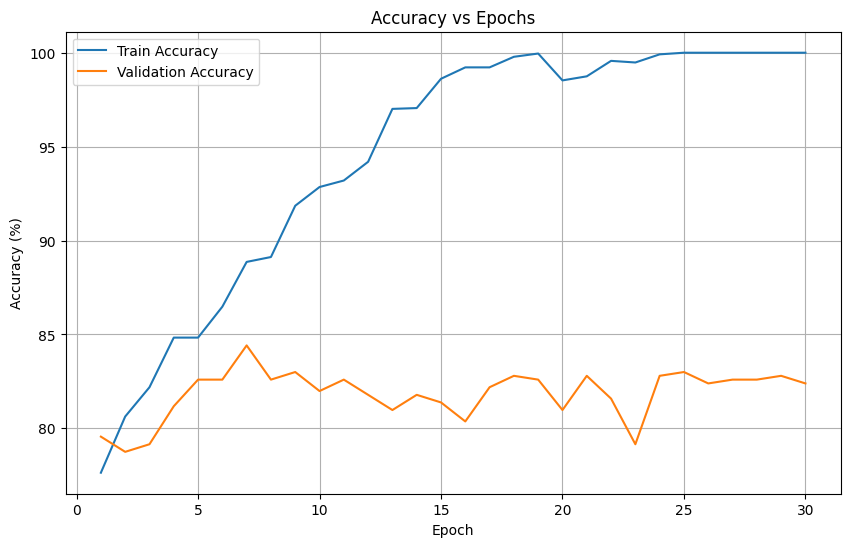

In [10]:
# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

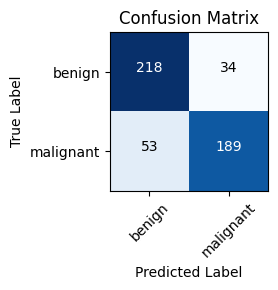

In [11]:
# Loading trained model for final evaluation
net6 = Net6()
net6.load_state_dict(torch.load(model_path, weights_only=True))
net6.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net6, valloader, classes)

In [12]:
# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net6(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net6.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net6(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

Accuracy for class on Validation: benign is 86.5 %
Accuracy for class on Validation: malignant is 78.1 %
Total Accuracy on Validation set: 82.39%


In [13]:
# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net6(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net6.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net6(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

Accuracy for class on Test set: benign is 88.4 %
Accuracy for class on Test set: malignant is 81.7 %
Total Accuracy on Test set: 85.48%


### Three layers 32 nodes (64FC model)

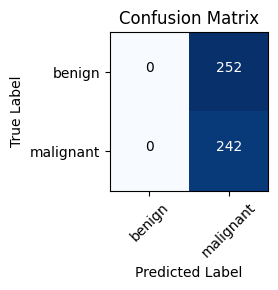

In [10]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # New additional layer
        self.fc1 = nn.Linear(64 * 16 * 16, 64)  # Adjust input size accordingly
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Pass through the new layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2 = Net2()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net2.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net2, valloader, classes)

In [11]:
print("Accuracy before training on validation set: ",round(242/(252 + 242),4))

Accuracy before training on validation set:  0.4899


Epoch 1: Train Accuracy: 74.21%, Val Accuracy: 77.73%
Epoch 2: Train Accuracy: 80.54%, Val Accuracy: 79.55%
Epoch 3: Train Accuracy: 82.70%, Val Accuracy: 79.96%
Epoch 4: Train Accuracy: 83.92%, Val Accuracy: 77.94%
Epoch 5: Train Accuracy: 85.83%, Val Accuracy: 81.58%
Epoch 6: Train Accuracy: 86.91%, Val Accuracy: 80.57%
Epoch 7: Train Accuracy: 87.69%, Val Accuracy: 77.73%
Epoch 8: Train Accuracy: 88.56%, Val Accuracy: 82.19%
Epoch 9: Train Accuracy: 89.81%, Val Accuracy: 81.38%
Epoch 10: Train Accuracy: 91.37%, Val Accuracy: 80.97%
Epoch 11: Train Accuracy: 92.93%, Val Accuracy: 82.39%
Epoch 12: Train Accuracy: 93.19%, Val Accuracy: 81.38%
Epoch 13: Train Accuracy: 95.45%, Val Accuracy: 82.59%
Epoch 14: Train Accuracy: 96.53%, Val Accuracy: 80.97%
Epoch 15: Train Accuracy: 96.71%, Val Accuracy: 80.16%
Epoch 16: Train Accuracy: 97.70%, Val Accuracy: 80.97%
Epoch 17: Train Accuracy: 95.80%, Val Accuracy: 82.39%
Epoch 18: Train Accuracy: 97.70%, Val Accuracy: 82.19%
Epoch 19: Train Acc

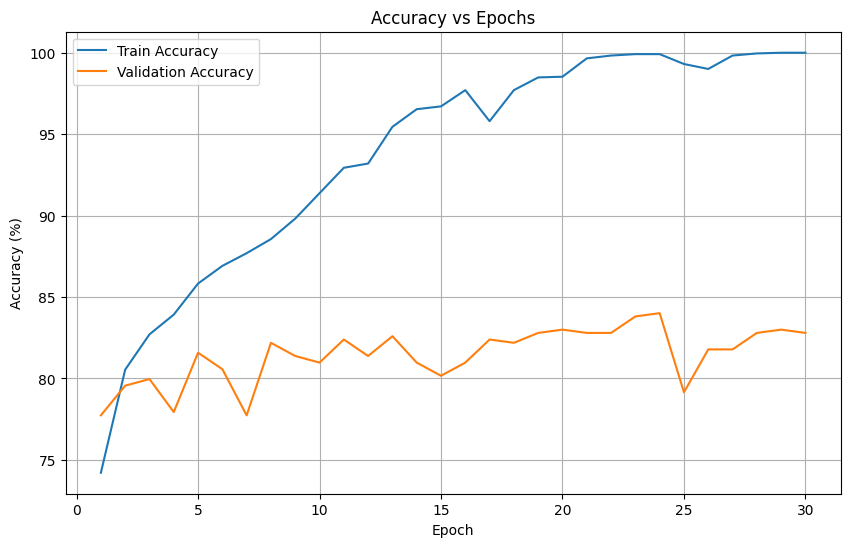

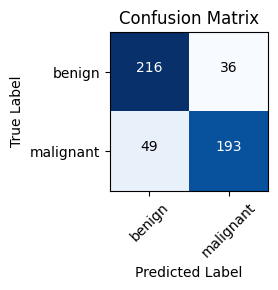

Accuracy for class on Validation: benign is 85.7 %
Accuracy for class on Validation: malignant is 79.8 %
Total Accuracy on Validation set: 82.79%
Accuracy for class on Test set: benign is 83.8 %
Accuracy for class on Test set: malignant is 78.5 %
Total Accuracy on Test set: 81.45%


In [12]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net2.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net2(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net2.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net2(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier2.pth"  # Path where the model will be saved
torch.save(net2.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net2 = Net2()
net2.load_state_dict(torch.load(model_path, weights_only=True))
net2.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net2, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net2.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net2.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Change Activation Functions LeakyReLU (64FC model)

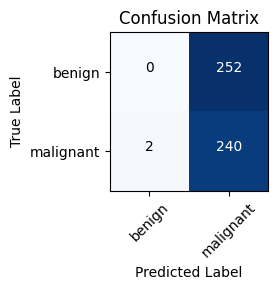

In [13]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)
        self.leaky_relu = nn.LeakyReLU(0.01)  # Define LeakyReLU with a small negative slope

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

net3 = Net3()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net3.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net3, valloader, classes)

In [14]:
print("Accuracy before training on validation set: ",round(240/(252 + 2 + 240),4))

Accuracy before training on validation set:  0.4858


Epoch 1: Train Accuracy: 77.03%, Val Accuracy: 78.95%
Epoch 2: Train Accuracy: 83.09%, Val Accuracy: 79.76%
Epoch 3: Train Accuracy: 84.87%, Val Accuracy: 80.97%
Epoch 4: Train Accuracy: 86.48%, Val Accuracy: 79.76%
Epoch 5: Train Accuracy: 88.47%, Val Accuracy: 82.59%
Epoch 6: Train Accuracy: 90.81%, Val Accuracy: 83.20%
Epoch 7: Train Accuracy: 92.85%, Val Accuracy: 81.17%
Epoch 8: Train Accuracy: 95.28%, Val Accuracy: 80.77%
Epoch 9: Train Accuracy: 96.19%, Val Accuracy: 81.98%
Epoch 10: Train Accuracy: 98.05%, Val Accuracy: 82.19%
Epoch 11: Train Accuracy: 97.92%, Val Accuracy: 83.81%
Epoch 12: Train Accuracy: 98.48%, Val Accuracy: 83.81%
Epoch 13: Train Accuracy: 99.35%, Val Accuracy: 81.38%
Epoch 14: Train Accuracy: 99.44%, Val Accuracy: 81.58%
Epoch 15: Train Accuracy: 100.00%, Val Accuracy: 83.00%
Epoch 16: Train Accuracy: 100.00%, Val Accuracy: 83.40%
Epoch 17: Train Accuracy: 100.00%, Val Accuracy: 83.00%
Epoch 18: Train Accuracy: 100.00%, Val Accuracy: 82.39%
Epoch 19: Train

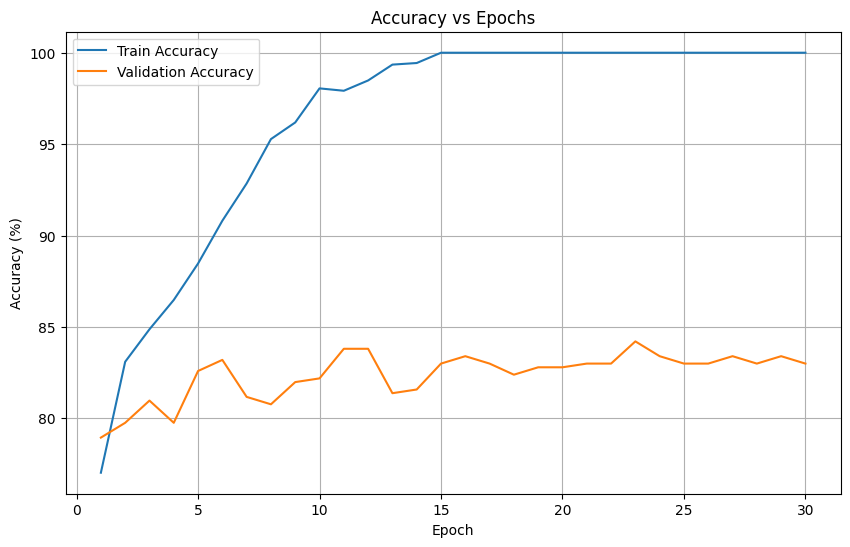

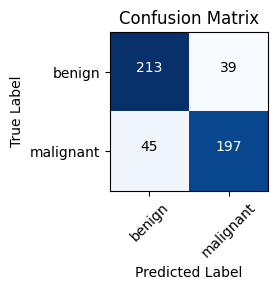

Accuracy for class on Validation: benign is 84.5 %
Accuracy for class on Validation: malignant is 81.4 %
Total Accuracy on Validation set: 83.00%
Accuracy for class on Test set: benign is 86.3 %
Accuracy for class on Test set: malignant is 80.4 %
Total Accuracy on Test set: 83.67%


In [15]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net3.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net3(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net3.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net3(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier3.pth"  # Path where the model will be saved
torch.save(net3.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net3 = Net3()
net3.load_state_dict(torch.load(model_path, weights_only=True))
net3.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net3, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net3(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net3.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net3(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net3.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Change Activation Functions Sigmoid (64 nodes FC model)

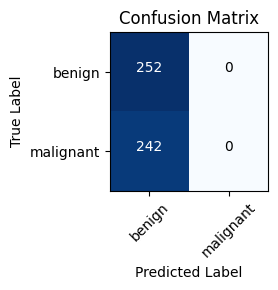

In [16]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)
        self.sigmoid = nn.Sigmoid()  # Logistic activation function 

    def forward(self, x):
        x = self.pool(self.sigmoid(self.conv1(x)))  # Sigmoid after conv1
        x = self.pool(self.sigmoid(self.conv2(x)))  # Sigmoid after conv2
        x = torch.flatten(x, 1)
        x = self.sigmoid(self.fc1(x))  # Sigmoid after fc1
        x = self.fc2(x)  # Final layer (CrossEntropyLoss does not need activation here)
        return x


net4 = Net4()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net4.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net4, valloader, classes)

In [17]:
print("Accuracy before training on validation set: ",round(252/(252 + 2 + 240),4))

Accuracy before training on validation set:  0.5101


Epoch 1: Train Accuracy: 45.38%, Val Accuracy: 51.01%
Epoch 2: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 3: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 4: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 5: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 6: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 7: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 8: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 9: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 10: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 11: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 12: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 13: Train Accuracy: 53.36%, Val Accuracy: 51.01%
Epoch 14: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 15: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 16: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 17: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 18: Train Accuracy: 55.09%, Val Accuracy: 51.01%
Epoch 19: Train Acc

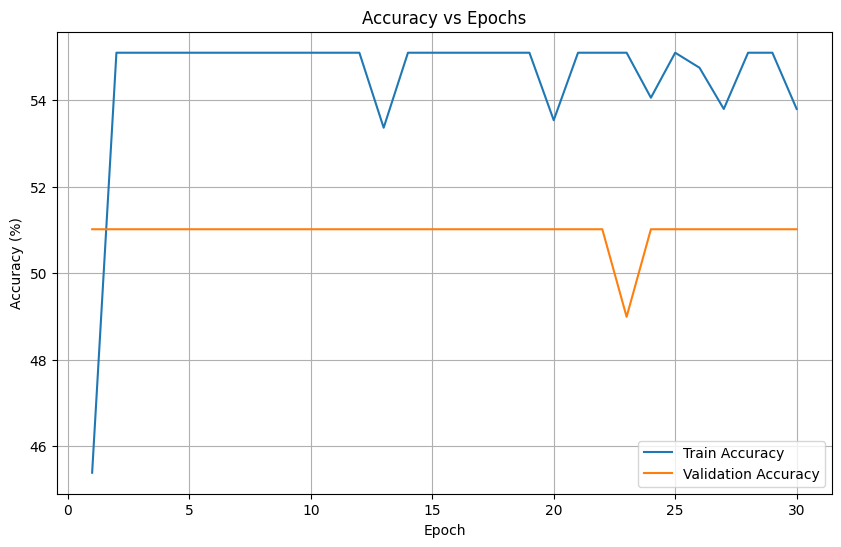

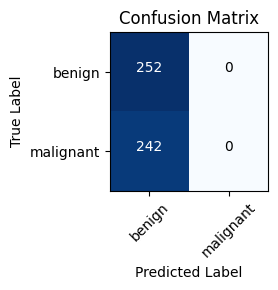

Accuracy for class on Validation: benign is 100.0 %
Accuracy for class on Validation: malignant is 0.0 %
Total Accuracy on Validation set: 51.01%
Accuracy for class on Test set: benign is 100.0 %
Accuracy for class on Test set: malignant is 0.0 %
Total Accuracy on Test set: 55.85%


In [18]:
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net4.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net4(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net4.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net4(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier4.pth"  # Path where the model will be saved
torch.save(net4.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net4 = Net4()
net4.load_state_dict(torch.load(model_path, weights_only=True))
net4.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net4, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net4(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net4.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net4(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net4.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

## 4 conv layers (64 nodes FC model)

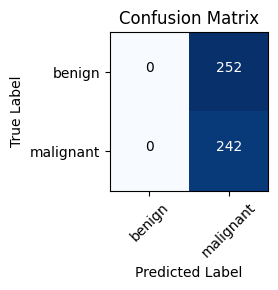

In [19]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)  # New additional layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Adjust input size accordingly
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  # Pass through the new layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net5 = Net5()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net5.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net5, valloader, classes)


Accuracy before training on validation set:  0.4899
Epoch 1: Train Accuracy: 75.25%, Val Accuracy: 79.15%
Epoch 2: Train Accuracy: 80.06%, Val Accuracy: 78.74%
Epoch 3: Train Accuracy: 80.10%, Val Accuracy: 79.96%
Epoch 4: Train Accuracy: 81.45%, Val Accuracy: 80.57%
Epoch 5: Train Accuracy: 83.09%, Val Accuracy: 80.77%
Epoch 6: Train Accuracy: 83.40%, Val Accuracy: 80.16%
Epoch 7: Train Accuracy: 84.57%, Val Accuracy: 80.57%
Epoch 8: Train Accuracy: 84.87%, Val Accuracy: 82.19%
Epoch 9: Train Accuracy: 86.69%, Val Accuracy: 82.39%
Epoch 10: Train Accuracy: 87.34%, Val Accuracy: 82.39%
Epoch 11: Train Accuracy: 87.91%, Val Accuracy: 83.40%
Epoch 12: Train Accuracy: 87.95%, Val Accuracy: 80.36%
Epoch 13: Train Accuracy: 89.47%, Val Accuracy: 83.40%
Epoch 14: Train Accuracy: 90.85%, Val Accuracy: 79.35%
Epoch 15: Train Accuracy: 90.94%, Val Accuracy: 82.39%
Epoch 16: Train Accuracy: 92.41%, Val Accuracy: 78.54%
Epoch 17: Train Accuracy: 92.59%, Val Accuracy: 83.00%
Epoch 18: Train Accura

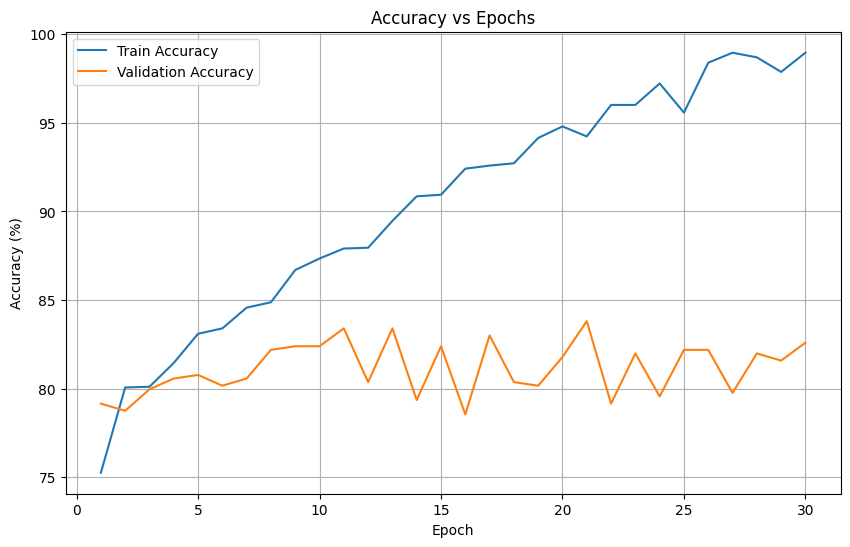

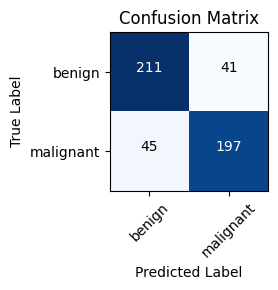

Accuracy for class on Validation: benign is 83.7 %
Accuracy for class on Validation: malignant is 81.4 %
Total Accuracy on Validation set: 82.59%
Accuracy for class on Test set: benign is 83.8 %
Accuracy for class on Test set: malignant is 84.0 %
Total Accuracy on Test set: 83.87%


In [20]:
print("Accuracy before training on validation set: ",round((242)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net5.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net5(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net5.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net5(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier5_64nodes.pth"  # Path where the model will be saved
torch.save(net5.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net5 = Net5()
net5.load_state_dict(torch.load(model_path, weights_only=True))
net5.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net5, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net5(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net5.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net5(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net5.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net5(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Different number of nodes in FC 45

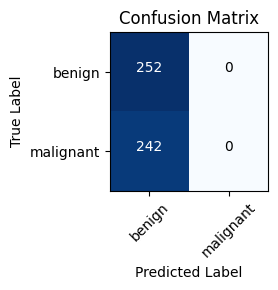

In [6]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net8(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net8, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 45)  # Fully connected layer (input size: 32*32*32, output size: 64)
        self.fc2 = nn.Linear(45, 2)  # Fully connected layer (input size: 64, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x


net8 = Net8()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net8.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net8, valloader, classes)


Accuracy before training on validation set:  0.5101
Epoch 1: Train Accuracy: 76.25%, Val Accuracy: 78.54%
Epoch 2: Train Accuracy: 82.40%, Val Accuracy: 80.97%
Epoch 3: Train Accuracy: 84.27%, Val Accuracy: 81.98%
Epoch 4: Train Accuracy: 86.69%, Val Accuracy: 81.38%
Epoch 5: Train Accuracy: 89.16%, Val Accuracy: 83.20%
Epoch 6: Train Accuracy: 91.33%, Val Accuracy: 81.38%
Epoch 7: Train Accuracy: 93.28%, Val Accuracy: 79.15%
Epoch 8: Train Accuracy: 93.63%, Val Accuracy: 81.17%
Epoch 9: Train Accuracy: 96.19%, Val Accuracy: 82.59%
Epoch 10: Train Accuracy: 97.31%, Val Accuracy: 78.54%
Epoch 11: Train Accuracy: 96.49%, Val Accuracy: 83.20%
Epoch 12: Train Accuracy: 98.18%, Val Accuracy: 84.21%
Epoch 13: Train Accuracy: 99.57%, Val Accuracy: 82.19%
Epoch 14: Train Accuracy: 99.87%, Val Accuracy: 84.21%
Epoch 15: Train Accuracy: 100.00%, Val Accuracy: 82.59%
Epoch 16: Train Accuracy: 99.96%, Val Accuracy: 81.38%
Epoch 17: Train Accuracy: 100.00%, Val Accuracy: 82.19%
Epoch 18: Train Accu

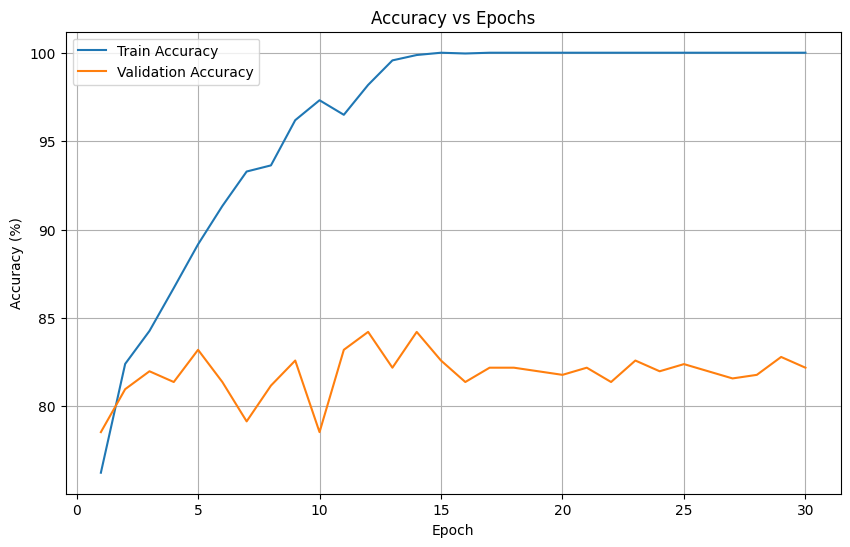

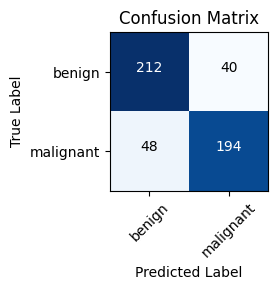

Accuracy for class on Validation: benign is 84.1 %
Accuracy for class on Validation: malignant is 80.2 %
Total Accuracy on Validation set: 82.19%
Accuracy for class on Test set: benign is 85.2 %
Accuracy for class on Test set: malignant is 79.9 %
Total Accuracy on Test set: 82.86%


In [7]:
print("Accuracy before training on validation set: ",round((252)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net8.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net8(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net8.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net8(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier8.pth"  # Path where the model will be saved
torch.save(net8.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net8 = Net8()
net8.load_state_dict(torch.load(model_path, weights_only=True))
net8.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net8, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net8(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net8.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net8(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net8(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net8.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net8(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Different number of nodes in FC 85

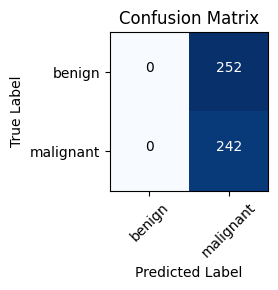

In [8]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net9(nn.Module):
    # layers of the neural network:
    def __init__(self):
        super(Net9, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # First convolutional layer (input: 3 channels, output: 16 channels, kernel size: 3x3)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with a 2x2 window and stride of 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32 channels, kernel size: 3x3)
        self.fc1 = nn.Linear(32 * 32 * 32, 85)  # Fully connected layer (input size: 32*32*32, output size: 64)
        self.fc2 = nn.Linear(85, 2)  # Fully connected layer (input size: 64, output size: 2 for binary classification)

    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU activation after conv1 and then max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU activation after conv2 and then max pooling
        x = torch.flatten(x, 1)  # Flatten the output to feed into the fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU activation after the first fully connected layer
        x = self.fc2(x)  # Output layer (no activation here, as we're using CrossEntropyLoss which combines softmax)
        return x


net9 = Net9()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net9.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net9, valloader, classes)


Accuracy before training on validation set:  0.4899
Epoch 1: Train Accuracy: 74.77%, Val Accuracy: 77.33%
Epoch 2: Train Accuracy: 80.97%, Val Accuracy: 80.97%
Epoch 3: Train Accuracy: 83.83%, Val Accuracy: 81.17%
Epoch 4: Train Accuracy: 85.26%, Val Accuracy: 82.59%
Epoch 5: Train Accuracy: 85.91%, Val Accuracy: 81.58%
Epoch 6: Train Accuracy: 87.95%, Val Accuracy: 83.81%
Epoch 7: Train Accuracy: 90.03%, Val Accuracy: 83.81%
Epoch 8: Train Accuracy: 91.89%, Val Accuracy: 80.97%
Epoch 9: Train Accuracy: 92.89%, Val Accuracy: 81.17%
Epoch 10: Train Accuracy: 93.11%, Val Accuracy: 80.97%
Epoch 11: Train Accuracy: 96.49%, Val Accuracy: 81.17%
Epoch 12: Train Accuracy: 97.57%, Val Accuracy: 81.78%
Epoch 13: Train Accuracy: 97.96%, Val Accuracy: 81.78%
Epoch 14: Train Accuracy: 99.35%, Val Accuracy: 82.39%
Epoch 15: Train Accuracy: 99.74%, Val Accuracy: 81.58%
Epoch 16: Train Accuracy: 99.87%, Val Accuracy: 82.79%
Epoch 17: Train Accuracy: 100.00%, Val Accuracy: 82.19%
Epoch 18: Train Accur

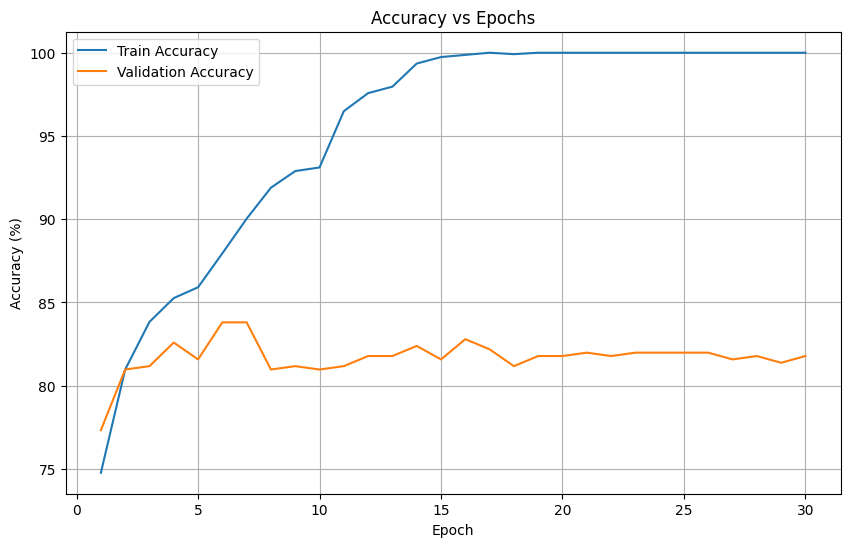

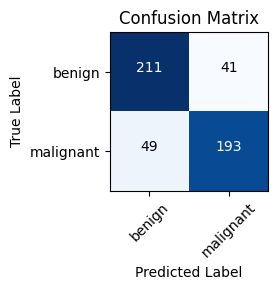

Accuracy for class on Validation: benign is 83.7 %
Accuracy for class on Validation: malignant is 79.8 %
Total Accuracy on Validation set: 81.78%
Accuracy for class on Test set: benign is 87.0 %
Accuracy for class on Test set: malignant is 79.5 %
Total Accuracy on Test set: 83.67%


In [9]:
print("Accuracy before training on validation set: ",round((242)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net9.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net9(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net9.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net9(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier8.pth"  # Path where the model will be saved
torch.save(net9.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net9 = Net9()
net9.load_state_dict(torch.load(model_path, weights_only=True))
net9.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net9, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net9(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net9.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net9(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net9(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net9.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net9(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Three conv layers (64 nodes in FC model)

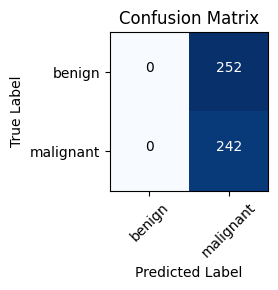

In [25]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN
class Net10(nn.Module):
    def __init__(self):
        super(Net10, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  # New additional layer
        self.fc1 = nn.Linear(64 * 16 * 16, 64)  # Adjust input size accordingly
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Pass through the new layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net10 = Net10()

# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks
# Optimizer
optimizer = optim.Adam(net10.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net10, valloader, classes)

Accuracy before training on validation set:  0.4899
Epoch 1: Train Accuracy: 76.46%, Val Accuracy: 80.36%
Epoch 2: Train Accuracy: 81.97%, Val Accuracy: 78.74%
Epoch 3: Train Accuracy: 82.96%, Val Accuracy: 80.97%
Epoch 4: Train Accuracy: 84.09%, Val Accuracy: 82.39%
Epoch 5: Train Accuracy: 85.48%, Val Accuracy: 81.38%
Epoch 6: Train Accuracy: 87.56%, Val Accuracy: 80.36%
Epoch 7: Train Accuracy: 87.99%, Val Accuracy: 80.57%
Epoch 8: Train Accuracy: 90.12%, Val Accuracy: 81.98%
Epoch 9: Train Accuracy: 91.20%, Val Accuracy: 79.96%
Epoch 10: Train Accuracy: 92.15%, Val Accuracy: 83.00%
Epoch 11: Train Accuracy: 93.84%, Val Accuracy: 79.76%
Epoch 12: Train Accuracy: 95.32%, Val Accuracy: 82.19%
Epoch 13: Train Accuracy: 97.70%, Val Accuracy: 80.97%
Epoch 14: Train Accuracy: 97.49%, Val Accuracy: 82.79%
Epoch 15: Train Accuracy: 98.96%, Val Accuracy: 81.17%
Epoch 16: Train Accuracy: 98.27%, Val Accuracy: 80.97%
Epoch 17: Train Accuracy: 98.05%, Val Accuracy: 80.57%
Epoch 18: Train Accura

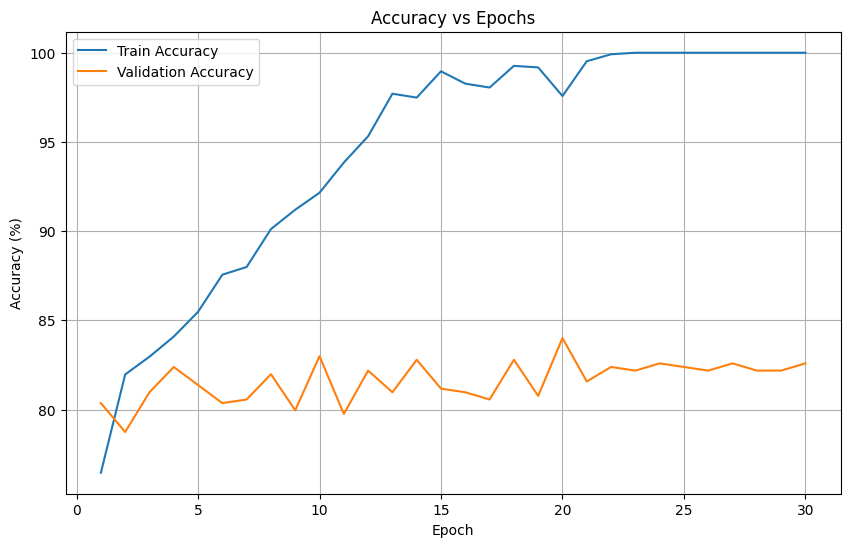

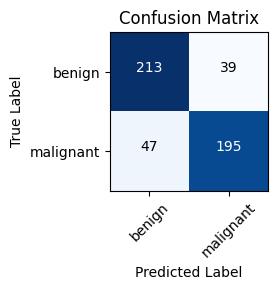

Accuracy for class on Validation: benign is 84.5 %
Accuracy for class on Validation: malignant is 80.6 %
Total Accuracy on Validation set: 82.59%
Accuracy for class on Test set: benign is 85.6 %
Accuracy for class on Test set: malignant is 82.2 %
Total Accuracy on Test set: 84.07%


In [26]:
print("Accuracy before training on validation set: ",round((242)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net10.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net10(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net10.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net10(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier10.pth"  # Path where the model will be saved
torch.save(net10.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net10 = Net10()
net10.load_state_dict(torch.load(model_path, weights_only=True))
net10.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net10, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net10(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net10.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net10(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net10(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net10.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net10(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### One single conv layer (64 FC nodes model)

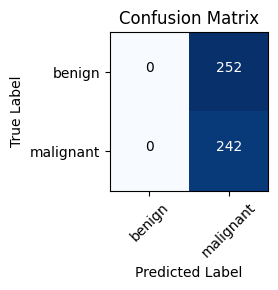

In [33]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN with a single convolutional layer
class Net11(nn.Module):
    def __init__(self):
        super(Net11, self).__init__()
        # Change the number of input channels from 3 to 16
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)               # Max pooling
        self.fc1 = nn.Linear(64 * 64 * 64, 64)       # Adjust input size after pooling
        self.fc2 = nn.Linear(64, 2)                  # Output layer for two classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))         # Pass through convolutional layer
        x = torch.flatten(x, 1)                      # Flatten the tensor for the fully connected layers
        x = F.relu(self.fc1(x))                      # First fully connected layer
        x = self.fc2(x)                              # Output layer
        return x

net11 = Net11()


# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks

# Optimizer
optimizer = optim.Adam(net11.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net11, valloader, classes)


Accuracy before training on validation set:  0.4899
Epoch 1: Train Accuracy: 73.60%, Val Accuracy: 76.92%
Epoch 2: Train Accuracy: 80.97%, Val Accuracy: 80.16%
Epoch 3: Train Accuracy: 82.70%, Val Accuracy: 74.90%
Epoch 4: Train Accuracy: 86.09%, Val Accuracy: 78.74%
Epoch 5: Train Accuracy: 85.91%, Val Accuracy: 80.16%
Epoch 6: Train Accuracy: 88.38%, Val Accuracy: 80.77%
Epoch 7: Train Accuracy: 91.20%, Val Accuracy: 83.60%
Epoch 8: Train Accuracy: 92.93%, Val Accuracy: 82.79%
Epoch 9: Train Accuracy: 93.89%, Val Accuracy: 85.02%
Epoch 10: Train Accuracy: 94.71%, Val Accuracy: 80.16%
Epoch 11: Train Accuracy: 95.97%, Val Accuracy: 79.35%
Epoch 12: Train Accuracy: 93.02%, Val Accuracy: 82.39%
Epoch 13: Train Accuracy: 97.05%, Val Accuracy: 83.00%
Epoch 14: Train Accuracy: 98.40%, Val Accuracy: 82.79%
Epoch 15: Train Accuracy: 96.45%, Val Accuracy: 82.39%
Epoch 16: Train Accuracy: 97.49%, Val Accuracy: 83.60%
Epoch 17: Train Accuracy: 99.52%, Val Accuracy: 83.81%
Epoch 18: Train Accura

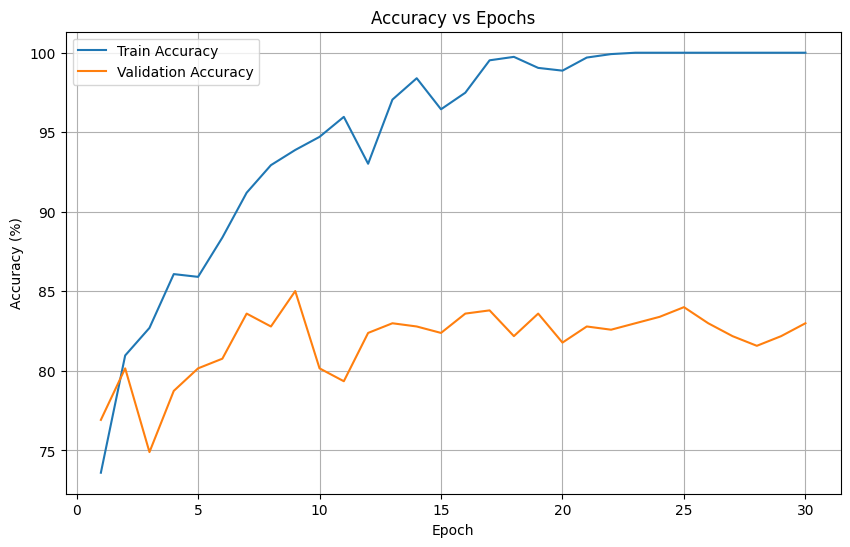

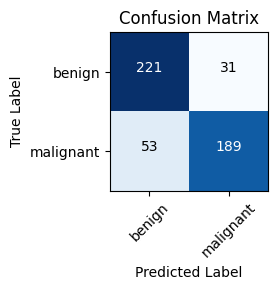

Accuracy for class on Validation: benign is 87.7 %
Accuracy for class on Validation: malignant is 78.1 %
Total Accuracy on Validation set: 83.00%
Accuracy for class on Test set: benign is 89.5 %
Accuracy for class on Test set: malignant is 79.0 %
Total Accuracy on Test set: 84.88%


In [34]:
print("Accuracy before training on validation set: ",round((242)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net11.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net11(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net11.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net11(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier11.pth"  # Path where the model will be saved
torch.save(net11.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net11 = Net11()
net11.load_state_dict(torch.load(model_path, weights_only=True))
net11.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net11, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net11(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net11.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net11(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net11(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net11.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net11(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')

### Three conv layers 32-32 - 64 FC

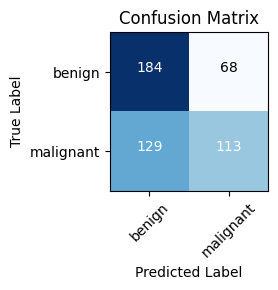

In [6]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining CNN with a single convolutional layer
class Net12(nn.Module):
    def __init__(self):
        super(Net12, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)  # New additional layer
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # Adjust input size accordingly
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Pass through the new layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net12 = Net12()


# Loss function
criterion = nn.CrossEntropyLoss()  # Define the loss function: Cross-Entropy Loss for classification tasks

# Optimizer
optimizer = optim.Adam(net12.parameters(), lr=0.001)  # Define the optimizer: Adam optimizer with learning rate 0.001

# Confusion matrix on validation set before training the model
plot_simple_confusion_matrix(net12, valloader, classes)


Accuracy before training on validation set:  0.6012
Epoch 1: Train Accuracy: 75.34%, Val Accuracy: 79.35%
Epoch 2: Train Accuracy: 80.97%, Val Accuracy: 79.55%
Epoch 3: Train Accuracy: 82.31%, Val Accuracy: 81.78%
Epoch 4: Train Accuracy: 82.53%, Val Accuracy: 81.17%
Epoch 5: Train Accuracy: 83.22%, Val Accuracy: 81.38%
Epoch 6: Train Accuracy: 85.13%, Val Accuracy: 81.58%
Epoch 7: Train Accuracy: 86.22%, Val Accuracy: 81.38%
Epoch 8: Train Accuracy: 86.91%, Val Accuracy: 83.60%
Epoch 9: Train Accuracy: 88.86%, Val Accuracy: 82.79%
Epoch 10: Train Accuracy: 88.64%, Val Accuracy: 79.35%
Epoch 11: Train Accuracy: 90.85%, Val Accuracy: 84.21%
Epoch 12: Train Accuracy: 92.72%, Val Accuracy: 82.79%
Epoch 13: Train Accuracy: 93.67%, Val Accuracy: 83.60%
Epoch 14: Train Accuracy: 95.19%, Val Accuracy: 82.39%
Epoch 15: Train Accuracy: 94.54%, Val Accuracy: 81.58%
Epoch 16: Train Accuracy: 96.79%, Val Accuracy: 82.59%
Epoch 17: Train Accuracy: 96.58%, Val Accuracy: 81.17%
Epoch 18: Train Accura

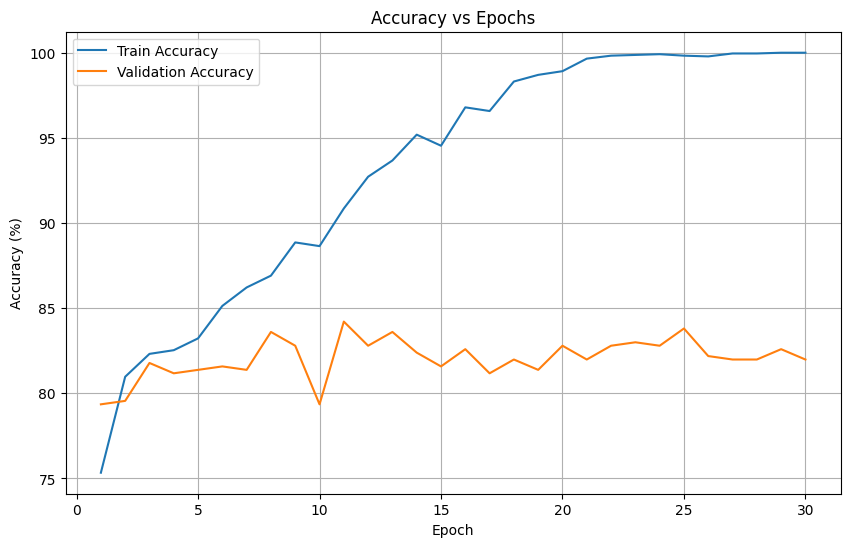

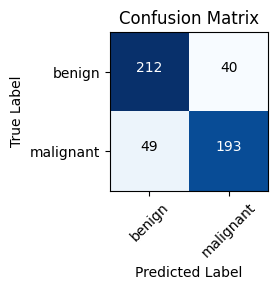

Accuracy for class on Validation: benign is 84.1 %
Accuracy for class on Validation: malignant is 79.8 %
Total Accuracy on Validation set: 81.98%
Accuracy for class on Test set: benign is 85.6 %
Accuracy for class on Test set: malignant is 84.5 %
Total Accuracy on Test set: 85.08%


In [7]:
print("Accuracy before training on validation set: ",round((184+113)/(242+252),4))
### MODEL'S  TRAINING  ###

train_accuracies = []  # List to store training accuracies for each epoch
val_accuracies = []  # List to store validation accuracies for each epoch

for epoch in range(30):  # Loop through 30 epochs
    net12.train()  # Set the model to training mode (important for layers like dropout and batch normalization)
    running_loss = 0.0  # Initialize running loss to track the loss during the epoch
    correct_train = 0  # Variable to count the number of correct predictions on the training set
    total_train = 0  # Total number of training samples processed

    for i, data in enumerate(trainloader, 0):  # Iterate through the training data loader
        inputs, labels = data  # Get the images and labels from the current batch
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation from previous iterations
        outputs = net12(inputs)  # Forward pass through the network
        loss = criterion(outputs, labels)  # Calculate the loss using the predicted outputs and true labels
        loss.backward()  # Backpropagation: Compute the gradients
        optimizer.step()  # Update the weights using the computed gradients

        running_loss += loss.item()  # Add the current batch's loss to the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class by selecting the class with the highest probability
        total_train += labels.size(0)  # Update the total number of samples processed
        correct_train += (predicted == labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the training set
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)  # Store the training accuracy for this epoch

    # Validation accuracy calculation
    net12.eval()  # Set the model to evaluation mode (important for layers like dropout)
    correct_val = 0  # Variable to count correct predictions on the validation set
    total_val = 0  # Total number of validation samples processed

    with torch.no_grad():  # Disable gradient calculation, as we're not training here
        for val_data in valloader:  # Iterate through the validation data loader
            val_inputs, val_labels = val_data  # Get the images and labels from the validation set
            val_outputs = net12(val_inputs)  # Get the model's predictions for the validation set
            _, val_predicted = torch.max(val_outputs, 1)  # Get the predicted classes
            total_val += val_labels.size(0)  # Update the total number of validation samples processed
            correct_val += (val_predicted == val_labels).sum().item()  # Update the count of correct predictions

    # Calculate the accuracy for the validation set
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)  # Store the validation accuracy for this epoch

    # Print the accuracy for this epoch
    print(f'Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')


model_path = "./skin_lesion_classifier12.pth"  # Path where the model will be saved
torch.save(net12.state_dict(), model_path)  # Save the model's state_dict (weights) to the specified path
print(f"Model saved in {model_path}")  # Print the confirmation message

# Plotting train and validation accuracy along epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loading trained model for final evaluation
net12 = Net12()
net12.load_state_dict(torch.load(model_path, weights_only=True))
net12.eval()
# print("Model loaded for evaluation")

# Confusion matrix on validation after training
plot_simple_confusion_matrix(net12, valloader, classes)

# VALIDATION
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net12(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Validation: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net12.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net12(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Validation set: {100 * correct / total:.2f}%')

# TEST
# Class-wise accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net12(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class on Test set: {classname:5s} is {accuracy:.1f} %')

# Total accuracy
net12.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net12(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total Accuracy on Test set: {100 * correct / total:.2f}%')